## Stochastic MPC using State Estimation and Terminal Cost

# Specify perturbation

In [1]:
import numpy as np

# np.random.seed(42)
nx = 25  # number of grid blocks
Ne = 10 # number of perturbation
# amean = 5.0
bmean = 9.0
# a_std = amean/3
b_std = bmean/3
# amin = 3.5
# amax = 6.5
bmin = 6
bmax = 12

# aw.shape

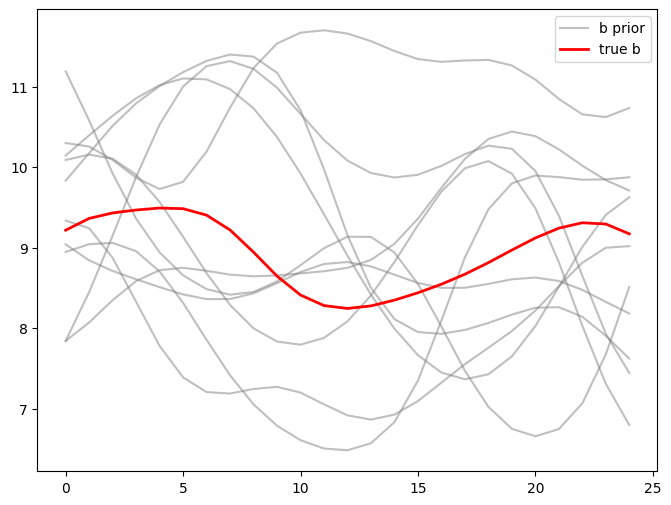

In [2]:
import gstools as gs
import scipy.stats



if False:
    bw = np.zeros((nx, Ne))
    
    for i in range(Ne):
        model = gs.Gaussian(dim=1, var=0.5, len_scale=5)
        srf = gs.SRF(model)
        x = range(25)
        srf(x, mesh_type='structured')
        fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
        a = (bmin - bmean) / b_std
        b = (bmax - bmean) / b_std
        var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
        _bw = var*b_std + bmean

        bw[:,i] = _bw

    np.save("./data/bw.npy", bw)
    
if False: 
    model = gs.Gaussian(dim=1, var=0.5, len_scale=5)
    srf = gs.SRF(model)
    x = range(25)
    srf(x, mesh_type='structured')
    fieldcdf = scipy.stats.norm.cdf(srf.field, 0, 1)
    a = (bmin - bmean) / b_std
    b = (bmax - bmean) / b_std
    var = scipy.stats.truncnorm.ppf(fieldcdf, a, b)
    _bw = var*b_std + bmean

    b_true = _bw*1
    
    np.save("./data/b_true.npy", b_true)
    
import matplotlib.pyplot as plt

bw = np.load("./data/bw.npy")
b_true = np.load("./data/b_true.npy")

fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=True)
ax.plot(bw, color='gray', alpha=0.5)
ax.plot(b_true, color='red', linewidth=2)
ax.plot([], color='gray', alpha=0.5, label="b prior")
ax.plot([], color='red', linewidth=2, label="true b")
ax.legend()
plt.show()

## Find the solution to the stochastic OCP solution 

In [3]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp_te import SolverOcp

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])


if False:
    # qocp = np.load("./data/stochastic_socp_qt.npy")[0]
    

    n_mpc_steps = 1
    N_mpc = 75

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)

    qocp = np.ones(params_mpc.Nt)
    nx = params_mpc.nx

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()

    qmpc = [1.0]

    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        if mpc_step == 0:
            f_discrete = ocp.bl.simulate_at_k
            f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        solver.set_initial_guess(Sw0, qt)
        x_traj, u_traj = solver.solve(Sw0)

    qocp = np.insert(u_traj[:,0], 0, 1.0)[:-1]
        

    # Compute the cost from the OCP solutions


    Sw_traj = []
    cost_traj = []
    for k, q in enumerate(qocp):
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, q)*(0.99**(k*0.03))
            # cost = -ocp.bl._stage_cost(Sw, q)*(1.0**k)
            # costs.append(cost.full()[0,0])
            costs.append(cost)
            
        Sw_mpc = f(Sw_mpc, q, aw, bw)
        Sw_traj.append(Sw_mpc)
        cost_traj.append(costs)
        

    qocp = np.array(qocp)
    Sw_traj = np.array(Sw_traj)  # (n_mpc_steps, nx*Ne)
    cost_traj = np.array(cost_traj)  # (n_mpc_steps, Ne)

    np.save("./data/socp_qocp.npy", qocp)
    np.save("./data/socp_Sw_traj.npy", Sw_traj)
    np.save("./data/socp_cost_traj.npy", cost_traj)
        

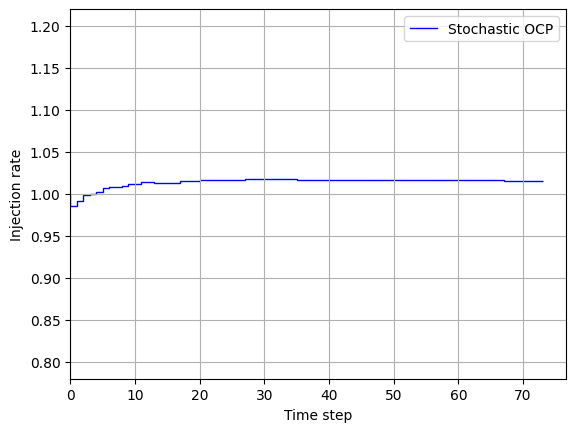

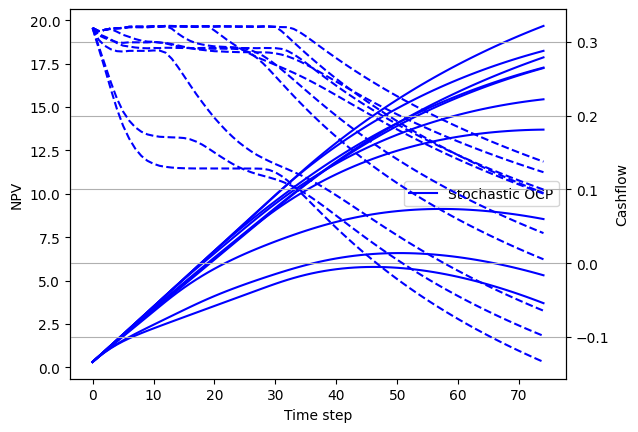

In [4]:

fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
ax.stairs(range(len(qocp)-1), qocp, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

ocp_cashflow = np.load("./data/socp_cost_traj.npy")[:,:,0,0]

fig, ax = plt.subplots()
ax.plot(np.cumsum(ocp_cashflow, axis=0), color='blue')
ax.plot([], color='blue', label="Stochastic OCP")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(ocp_cashflow, color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()


## Compute terminal cost using optimal control solution to the stochastic OCP

In [5]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp_te import SolverOcp

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])

if False:
    qocp = np.load("./data/socp_qocp.npy")

    n_mpc_steps = 100
    N_mpc = 10

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)

    nx = params_mpc.nx

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()

    qmpc = [1.0]
    Sw_traj = []

    cost_traj = []


    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        # if mpc_step == 0:
        f_discrete = ocp.bl.simulate_at_k
        f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**(mpc_step*0.03))
            # cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(1.0**mpc_step)
            costs.append(cost)
        cost_traj.append(costs)
        
        Sw_mpc = f(Sw_mpc, qmpc[-1], aw, bw)
        Sw_traj.append(Sw_mpc)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        # warm start
        if mpc_step == 0:
            solver.set_initial_guess(Sw0, qt)
        else:
            _qt = np.insert(u_traj[1:,0], N_mpc-1, u_traj[-1,0])
            solver.set_initial_guess(Sw0, _qt)
        x_traj, u_traj = solver.solve(Sw0)
        
        qmpc.append(u_traj[0,0]*1)
        
        
        
        

    qmpc = np.array(qmpc)
    Sw_traj = np.array(Sw_traj)  # (n_mpc_steps, nx*Ne)
    cost_traj = np.array(cost_traj)  # (n_mpc_steps, Ne)

    np.save("./data/smpc_qmpc.npy", qmpc)
    np.save("./data/smpc_Sw_traj.npy", Sw_traj)
    np.save("./data/smpc_cost_traj.npy", cost_traj)
        

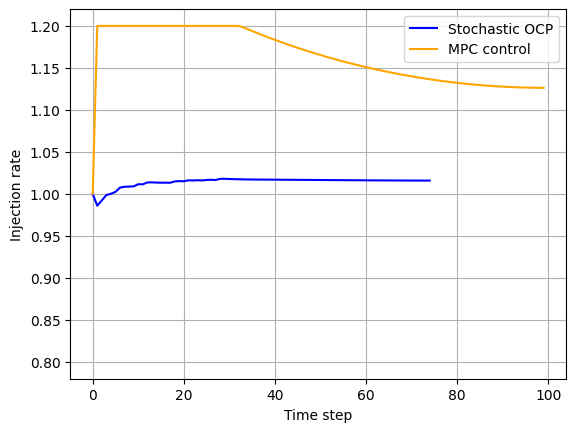

(13.702127706324301, 17.454583410207434)

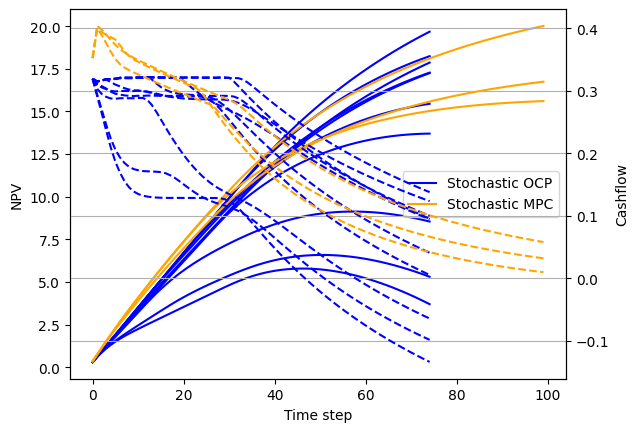

In [6]:
fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
qmpc = np.load("./data/smpc_qmpc.npy")
ax.plot(qocp, label="Stochastic OCP", color="blue")
plt.plot(qmpc[:-1], label="MPC control", color="orange")
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

socp_cost = np.load("./data/socp_cost_traj.npy")[:,:,0,0]
smpc_cost = np.load("./data/smpc_cost_traj.npy")[:,:,0,0]

fig, ax = plt.subplots()
ax.plot(np.cumsum(socp_cost, axis=0), color='blue')
ax.plot(np.cumsum(smpc_cost, axis=0), color='orange')
ax.plot([], color='blue', label="Stochastic OCP")
ax.plot([], color='orange', label="Stochastic MPC")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(socp_cost, color="blue", linestyle="dashed")
ax1.plot(smpc_cost, color="orange", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()


npv_socp = np.cumsum(socp_cost, axis=0)[-1,:].mean()
npv_smpc = np.cumsum(smpc_cost, axis=0)[-1,:].mean()

npv_socp, npv_smpc

## Compute the cost using the optimal control on the true model, then update the parameter

In [7]:


import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue
from solver_socp_te import SolverOcp

from kalman_filter import ESMDA

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw")
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym, bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])

if False:
    qocp = np.load("./data/socp_qocp.npy")
    bw = np.load("./data/bw.npy")
    b_true = np.load("./data/b_true.npy")


    n_mpc_steps = 75
    N_mpc = 5

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)

    params_mpc_true = BLParamsTrue(N_mpc = N_mpc, 
                                Ne = 1,
                                nx = nx,
                                bw = b_true[:,np.newaxis])

    esmda = ESMDA(m=bw, g_func=None, g_obs=np.array([0.01]), alphas=[], cd=[0.01])

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()
    Sw_true = np.array(_Sw0.copy())

    qmpc = [1.0]

    cost_traj = []

    Sw_traj = []
    Sw_true_traj = []

    bw_traj = []
    
    n_obs_data_count = 0
    N_obs = 10 # number of data points to be used simultaneously in the parm estimation
    is_breakthrough = False
    g_meas = np.zeros((Ne, N_obs))
    g_obs = np.zeros((N_obs))
    
    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)
        
        ocp = setup_sbl_ocp(params_mpc, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        ocp_true = setup_sbl_ocp(params_mpc_true, 
                            qmpc=qmpc,
                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        a_true = params_mpc_true.aw
        b_true = params_mpc_true.bw
        
        if mpc_step == 0:
            f_discrete = ocp.bl.simulate_at_k
            f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        # activate parameter estimation procedure here
        # only when water breakthrough is observed, i.e., saturation at production well > 0.5
        # if Sw_true[-1] > 0.5 for any i in range(Ne)
                
        if Sw_true[-1] > 0.2:
            
            if not is_breakthrough:
                t_breakthrough = mpc_step*1
                is_breakthrough = True
            
            # collect ensemble response
            for i in range(Ne):
                Sw_last = Sw_mpc[(i+1)*nx-1]
                g_meas[i, n_obs_data_count] = Sw_last
                    
            # collect observed response
            g_obs[n_obs_data_count] = Sw_true[-1]
                    
            if n_obs_data_count < N_obs-1:
                n_obs_data_count += 1
                
            else:
                # perform parameter estimation update here
                    
                # g_meas = np.array([g_meas]).T    
                # g_obs = np.array(Sw_true[[-1]])
                
                NiterESMDA = 1 
                
                # for ii in range(NiterESMDA):
                # cd = np.array([0.00000001]*N_obs)
                cd = np.array([0.000005]*N_obs)
                # cd = np.array([0.0001]*N_obs)
                
                bw_post = esmda.update(bw.T, g_meas, g_obs, 1, cd)
                bw = bw_post.T
                
                bw_traj.append(bw)
        
                # reset 
                g_meas = np.zeros((Ne, N_obs))
                g_obs = np.zeros((N_obs))
                n_obs_data_count = 0
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**(mpc_step*0.03))
            # cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(1.0**mpc_step)
            costs.append(cost)
        cost_traj.append(costs)
        
        # simulate the ensemble
        Sw_mpc = f(Sw_mpc, qmpc[-1], aw, bw).full()[:,0]

        # simulate the true model
        Sw_true = f_discrete(Sw_true, qmpc[-1], aw, b_true[:,0]).full()[:,0]
        
        solver = SolverOcp(ocp, itk=mpc_step)
        
        # warm start
        if mpc_step == 0:
            solver.set_initial_guess(Sw0, qt)
        else:
            _qt = np.insert(u_traj[1:,0], N_mpc-1, u_traj[-1,0])
            solver.set_initial_guess(Sw0, _qt)
            
        x_traj, u_traj = solver.solve(Sw0)
        
        qmpc.append(u_traj[0,0]*1)
        
        Sw_traj.append(Sw_mpc)
        Sw_true_traj.append(Sw_true)
        
        
    cost_traj = np.array(cost_traj)
    
    np.save("./data/bw_traj.npy", bw_traj)

    np.save("./data/smpc_wse_qmpc.npy", qmpc) # wse = with state estimation 
    np.save("./data/smpc_wse_Sw_traj.npy", Sw_traj)
    np.save("./data/smpc_wse_cost_traj.npy", cost_traj)

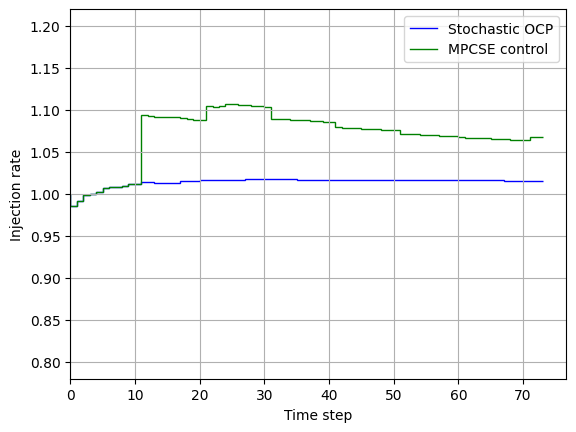

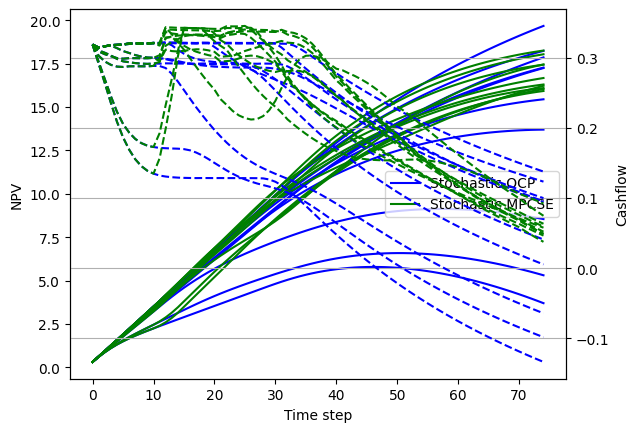

In [8]:
fig, ax = plt.subplots()
qocp = np.load("./data/socp_qocp.npy")
# qmpc = np.load("./data/smpc_qmpc.npy")
qmpc_wse = np.load("./data/smpc_wse_qmpc.npy")
ax.stairs(range(len(qocp)-1), qocp, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
# ax.plot(qmpc[:-1], label="MPC control", color="orange")
ax.stairs(range(len(qmpc_wse[:-1])-1), qmpc_wse[:-1], label="MPCSE control", color="green", orientation="horizontal", baseline=None)
ax.legend()
ax.set_ylabel("Injection rate")
ax.set_xlabel("Time step")
ax.set_ylim([0.78, 1.22])
ax.grid()
plt.show()

socp_cost = np.load("./data/socp_cost_traj.npy")[:,:,0,0]
smpc_cost = np.load("./data/smpc_cost_traj.npy")[:,:,0,0]
smpc_cost_wse = np.load("./data/smpc_wse_cost_traj.npy")[:,:,0,0]

fig, ax = plt.subplots()
ax.plot(np.cumsum(socp_cost, axis=0), color='blue')
# ax.plot(np.cumsum(smpc_cost, axis=0), color='orange')
ax.plot(np.cumsum(smpc_cost_wse, axis=0), color='green')
ax.plot([], color='blue', label="Stochastic OCP")
# ax.plot([], color='orange', label="Stochastic MPC")
ax.plot([], color='green', label="Stochastic MPCSE")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(socp_cost, color="blue", linestyle="dashed")
# ax1.plot(smpc_cost, color="orange", linestyle="dashed")
ax1.plot(smpc_cost_wse, color="green", linestyle="dashed")
ax1.set_ylabel("Cashflow")

ax1.grid()



# Sanity check: calculate the cost using the same cost function for all the optimal controls

In [9]:

from buckley_leverette_te import BuckleyLeverette
from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue

def calculate_cost(f_discrete, Swinit, qseq, aw, bw, Ne, nx):
    """Calculate cost function

    Args:
        Swinit (_type_): Initial Sw, shape (nx, Ne)
        qseq (_type_): Control sequence, shape (Nt)
        aw: a uncertainty, shape (nx, Ne)
        bw: b uncertainty, shape (nx, Ne)
    """
    
    Sw = Swinit*1
    
    cost_traj = []
    for k, q in enumerate(qseq):
        costs = []
        new_Sw = []
        for i in range(Ne):
            _Sw = Sw[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(_Sw, q)*(0.99**(k*0.03))
            # cost = -ocp.bl._stage_cost(_Sw, q)*(1.0**k)
            costs.append(cost.full()[0,0])
            
            _Sw = f_discrete(_Sw, q, aw, bw[:,i]).full()[:,0]
            new_Sw.extend(_Sw)
            
        cost_traj.append(costs)
        Sw = np.array(new_Sw)
        
    return np.array(cost_traj)
        

N_mpc = 5
aw = 5.0
    
params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)

qocp = np.load("./data/socp_qocp.npy")
qmpc = [1.0]

ocp = setup_sbl_ocp(params_mpc, 
                    qmpc=qmpc,
                    qocp=qocp)
    

f_discrete = ocp.bl.simulate_at_k
aw = 5.0    

# Stochastic OCP
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qocp = np.load("./data/socp_qocp.npy")
bw = np.load("./data/bw.npy")
socp_cost = calculate_cost(f_discrete, Sw0, qocp, aw, bw, Ne, nx)

# Stochastic MPC
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc = np.load("./data/smpc_qmpc.npy")
bw = np.load("./data/bw.npy")
smpc_cost = calculate_cost(f_discrete, Sw0, qsmpc, aw, bw, Ne, nx)

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), 1.0, 0.9860728273578363, 0.9921665521661372, 0.9986224513494707, 1.000186850868721, 1.0024029390634082, 1.007542733364672, 1.0085299027893577, 1.0086961326603316, 1.0090207949287464, 1.0115604698439327, 1.0114503494398506, 1.0137042078138783, 1.0137329768453338, 1.013504111141519, 1.0133088943002835, 1.0134111335361062, 1.0132870437820827, 1.0148456740342389, 1.0152668298726917, 1.0150717755919034, 1.0162031171409847, 1.0160025073598846, 1.0162900557868169, 1.016074821332625, 1.0165979873153717, 1.0168330841206832, 1.016573220142223, 1.017969501570439, 1.0179766832773094, 1.0177638373753153, 1.0175869953865138, 1.0174419089261038, 1.0173251807685526, 1.0172370730461269, 1.0171705760997447, 1.017117533336826, 1.017072341375578, 1.0170316225168836, 1.0169933373586693, 1.0169562133615326, 1.016919440671989, 1.016882509976707, 1.0168451191169305, 1.0168071136595445, 1.0167684457084067, 1.016729143

## Solution without using terminal cost



In [ ]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, setup_sbl_ocp_without_terminal, BLParamsSmpcShort
from solver_socp_te import SolverOcp

def make_ensemble_propagator(f_discrete, nx, Ne):
    Sw_flat = ca.SX.sym("Sw_flat", nx*Ne)
    u_sym = ca.SX.sym("u")
    aw_sym = ca.SX.sym("aw", nx, Ne)
    bw_sym = ca.SX.sym("bw", nx, Ne)
    outs = []
    for i in range(Ne):
        Si = Sw_flat[i*nx:(i+1)*nx]
        outs.append(f_discrete(Si, u_sym, aw_sym[:,i], bw_sym[:,i]))
        # outs.append(f_discrete(Si, u_sym, aw_sym[i], bw_sym[i]))
    Sw_next_flat = ca.vertcat(*outs)
    return ca.Function("propagate_ensemble", [Sw_flat, u_sym, aw_sym, bw_sym], [Sw_next_flat])

if True:
    qocp = np.load("./data/socp_qocp.npy")

    n_mpc_steps = 75
    N_mpc = 5

    params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)

    nx = params_mpc.nx

    qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

    u_traj = qt*1

    _Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
    Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
    Sw_mpc = Sw0.copy()

    qmpc = [1.0]
    Sw_traj = []

    cost_traj = []


    for mpc_step in tqdm(range(n_mpc_steps)):
        _qocp = qocp[(N_mpc+mpc_step):]
        
        ocp = setup_sbl_ocp_without_terminal(params_mpc, 
                                            qmpc=qmpc,
                                            qocp=_qocp)
        
        aw = params_mpc.aw
        bw = params_mpc.bw
        
        # if mpc_step == 0:
        f_discrete = ocp.bl.simulate_at_k
        f = make_ensemble_propagator(f_discrete, nx, Ne)
        
        
        costs = []
        for i in range(params_mpc.Ne):
            Sw = Sw_mpc[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**(mpc_step*0.03))
            # cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(1.0**mpc_step)
            costs.append(cost)
        cost_traj.append(costs)
        
        Sw_mpc = f(Sw_mpc, qmpc[-1], aw, bw)
        Sw_traj.append(Sw_mpc)
        
        solver = SolverOcp(ocp, itk=mpc_step)
        # warm start
        if mpc_step == 0:
            solver.set_initial_guess(Sw0, qt)
        else:
            _qt = np.insert(u_traj[1:,0], N_mpc-1, u_traj[-1,0])
            solver.set_initial_guess(Sw0, _qt)
        x_traj, u_traj = solver.solve(Sw0)
        
        qmpc.append(u_traj[0,0]*1)
        
        
        
        

    qmpc = np.array(qmpc)
    Sw_traj = np.array(Sw_traj)  # (n_mpc_steps, nx*Ne)
    cost_traj = np.array(cost_traj)  # (n_mpc_steps, Ne)

    np.save("./data/smpc_notc_qmpc.npy", qmpc)
    np.save("./data/smpc_notc_Sw_traj.npy", Sw_traj)
    np.save("./data/smpc_notc_cost_traj.npy", cost_traj)
        

  0%|          | 0/75 [00:00<?, ?it/s]

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9)]
Control sequence used in co

# Compute cost using the controls obtain from various method on the true model

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), 1.0, 0.9860728273578363, 0.9921665521661372, 0.9986224513494707, 1.000186850868721, 1.0024029390634082, 1.007542733364672, 1.0085299027893577, 1.0086961326603316, 1.0090207949287464, 1.0115604698439327, 1.0114503494398506, 1.0137042078138783, 1.0137329768453338, 1.013504111141519, 1.0133088943002835, 1.0134111335361062, 1.0132870437820827, 1.0148456740342389, 1.0152668298726917, 1.0150717755919034, 1.0162031171409847, 1.0160025073598846, 1.0162900557868169, 1.016074821332625, 1.0165979873153717, 1.0168330841206832, 1.016573220142223, 1.017969501570439, 1.0179766832773094, 1.0177638373753153, 1.0175869953865138, 1.0174419089261038, 1.0173251807685526, 1.0172370730461269, 1.0171705760997447, 1.017117533336826, 1.017072341375578, 1.0170316225168836, 1.0169933373586693, 1.0169562133615326, 1.016919440671989, 1.016882509976707, 1.0168451191169305, 1.0168

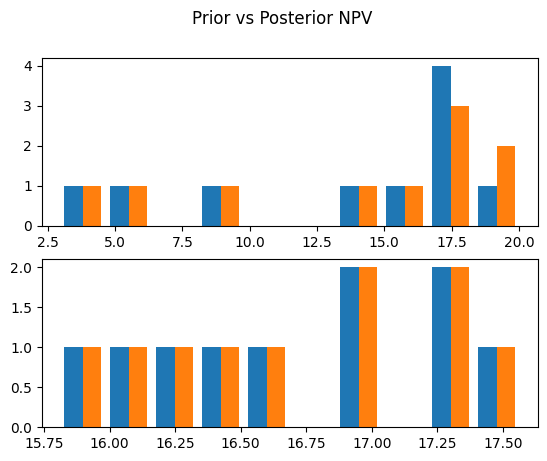

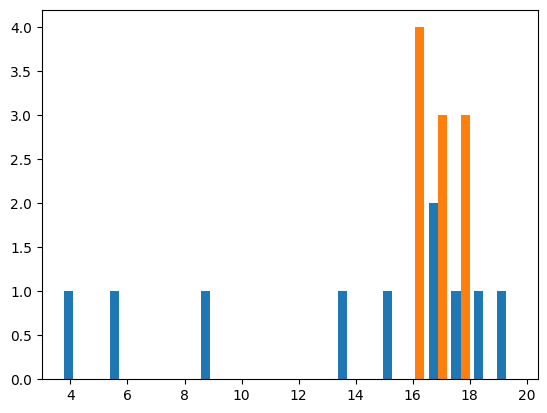

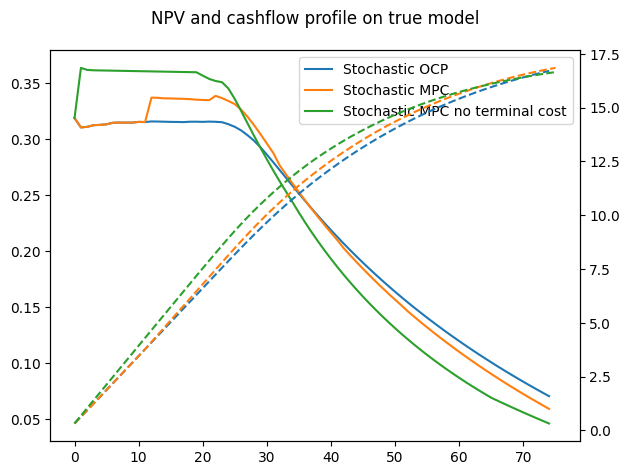

Cumulative cost at the last time step: [16.7018393] vs [16.78654656] 


In [24]:

from buckley_leverette_te import BuckleyLeverette
from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue

def calculate_cost(f_discrete, Swinit, qseq, aw, bw, Ne, nx):
    """Calculate cost function

    Args:
        Swinit (_type_): Initial Sw, shape (nx, Ne)
        qseq (_type_): Control sequence, shape (Nt)
        aw: a uncertainty, shape (nx, Ne)
        bw: b uncertainty, shape (nx, Ne)
    """
    
    Sw = Swinit*1
    
    cost_traj = []
    for k, q in enumerate(qseq):
        costs = []
        new_Sw = []
        for i in range(Ne):
            _Sw = Sw[i*nx:(i+1)*nx]
            cost = -ocp.bl._stage_cost(_Sw, q)*(0.99**(k*0.03))
            # cost = -ocp.bl._stage_cost(_Sw, q)*(1.0**k)
            costs.append(cost.full()[0,0])
            
            _Sw = f_discrete(_Sw, q, aw, bw[:,i]).full()[:,0]
            new_Sw.extend(_Sw)
            
        cost_traj.append(costs)
        Sw = np.array(new_Sw)
        
    return np.array(cost_traj)
        
    
## on true model
aw_true = np.load("./data/a_true.npy")
bw_true = np.load("./data/b_true.npy")

Ne = 1
nx = 25

params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw_true[:,np.newaxis])

qocp = np.load("./data/socp_qocp.npy")
qmpc = [1.0]

ocp = setup_sbl_ocp(params_mpc, 
                    qmpc=qmpc,
                    qocp=qocp)
    
f_discrete = ocp.bl.simulate_at_k
# Stochastic OCP
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qocp = np.load("./data/socp_qocp.npy")
true_socp_cost = calculate_cost(f_discrete, Sw0, qocp, aw, bw_true[:,np.newaxis], Ne, nx)
true_socp_cost_cum = np.cumsum(true_socp_cost, axis=0)

# Stochastic MPC
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc = np.load("./data/smpc_qmpc.npy")
true_smpc_cost = calculate_cost(f_discrete, Sw0, qsmpc, aw, bw_true[:,np.newaxis], Ne, nx)
true_smpc_cost_cum = np.cumsum(true_smpc_cost, axis=0)

# Stochastic MPC
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc_wse = np.load("./data/smpc_wse_qmpc.npy")
true_smpc_wse_cost = calculate_cost(f_discrete, Sw0, qsmpc_wse, aw, bw_true[:,np.newaxis], Ne, nx)
true_smpc_wse_cost_cum = np.cumsum(true_smpc_wse_cost, axis=0)

# Stochastic MPC without terminal cost
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc_wse = np.load("./data/smpc_notc_qmpc.npy")
true_smpc_notc_cost = calculate_cost(f_discrete, Sw0, qsmpc_wse, aw, bw_true[:,np.newaxis], Ne, nx)
true_smpc_notc_cost_cum = np.cumsum(true_smpc_notc_cost, axis=0)

## on prior vs posterior model
bw_prior = np.load("./data/bw.npy")

Ne = 10
nx = 25

params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw_prior)

qocp = np.load("./data/socp_qocp.npy")
qmpc = [1.0]

ocp = setup_sbl_ocp(params_mpc, 
                    qmpc=qmpc,
                    qocp=qocp)
    
f_discrete = ocp.bl.simulate_at_k
# Prior model using old optimal control
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qocp = np.load("./data/socp_qocp.npy")
prior_socp_cost = calculate_cost(f_discrete, Sw0, qocp, aw, bw_prior, Ne, nx)
prior_socp_cost_cum = np.cumsum(prior_socp_cost, axis=0)

# Prior model using new optimal control
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc_wse = np.load("./data/smpc_wse_qmpc.npy")
prior_smpc_wse_cost = calculate_cost(f_discrete, Sw0, qsmpc_wse, aw, bw_prior, Ne, nx)
prior_smpc_wse_cost_cum = np.cumsum(prior_smpc_wse_cost, axis=0)[:-1,:]

aw_post = np.load("./data/aw_traj.npy")[-1,:,:]
bw_post = np.load("./data/bw_traj.npy")[-1,:,:]

params_mpc = BLParamsSmpcShort(N_mpc = N_mpc, 
                                Ne = Ne,
                                nx = nx,
                                bw = aw_post)

qocp = np.load("./data/socp_qocp.npy")
qmpc = [1.0]

ocp = setup_sbl_ocp(params_mpc, 
                    qmpc=qmpc,
                    qocp=qocp)
    
f_discrete = ocp.bl.simulate_at_k
# Posterior model using old optimal control
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qocp = np.load("./data/socp_qocp.npy")
post_socp_cost = calculate_cost(f_discrete, Sw0, qocp, aw, bw_post, Ne, nx)
post_socp_cost_cum = np.cumsum(post_socp_cost, axis=0)

# Posterior model using new optimal control
_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*Ne)  # initial state
qsmpc_wse = np.load("./data/smpc_wse_qmpc.npy")
post_smpc_wse_cost = calculate_cost(f_discrete, Sw0, qsmpc_wse, aw, bw_post, Ne, nx)
post_smpc_wse_cost_cum = np.cumsum(post_smpc_wse_cost, axis=0)[:-1,:]

## Plotting
data_prior = [prior_socp_cost_cum[-1,:], prior_smpc_wse_cost_cum[-1,:]]
data_post = [post_socp_cost_cum[-1,:], post_smpc_wse_cost_cum[-1,:]]
fig, ax = plt.subplots(2,1,sharex=False)
fig.suptitle("Prior vs Posterior NPV")
ax[0].hist(data_prior, bins=10)
ax[1].hist(data_post, bins=10)
plt.show()

plt.figure()
data = [prior_socp_cost_cum[-1,:], post_smpc_wse_cost_cum[-1,:]]
plt.hist(data, bins=20)

# cost comparison of smpc vs socp control on true model

# data_true = [true_socp_cost_cum[-1,:], true_smpc_wse_cost_cum[-1,:]]
fig, ax = plt.subplots()
fig.suptitle("NPV and cashflow profile on true model")
ax.plot(true_socp_cost, label="Stochastic OCP")
ax.plot(true_smpc_wse_cost[:-1], label="Stochastic MPC")
ax.plot(true_smpc_notc_cost[:-1], label="Stochastic MPC no terminal cost")
ax.legend()
ax2 = ax.twinx()
ax2.plot(true_socp_cost_cum, linestyle="dashed") 
ax2.plot(true_smpc_wse_cost_cum, linestyle="dashed")
ax2.plot(true_smpc_notc_cost_cum, linestyle="dashed")

fig.tight_layout()
plt.show()
# plt.legend()
print(f"Cumulative cost at the last time step: {true_socp_cost_cum[-1]} vs {true_smpc_wse_cost_cum[-2]} ")


In [21]:
true_socp_cost_cum[:,:]

array([[ 0.31887452],
       [ 0.62942296],
       [ 0.9404822 ],
       [ 1.25299307],
       [ 1.56577751],
       [ 1.87908445],
       [ 2.19376154],
       [ 2.50862377],
       [ 2.82343813],
       [ 3.13824981],
       [ 3.45368684],
       [ 3.7689976 ],
       [ 4.08485027],
       [ 4.40061584],
       [ 4.71622166],
       [ 5.03167727],
       [ 5.34706662],
       [ 5.6623259 ],
       [ 5.977929  ],
       [ 6.29355535],
       [ 6.60903174],
       [ 6.92473063],
       [ 7.24027809],
       [ 7.55543658],
       [ 7.86882652],
       [ 8.17984852],
       [ 8.48761672],
       [ 8.79105585],
       [ 9.08968586],
       [ 9.38237897],
       [ 9.66855341],
       [ 9.94789777],
       [10.2202554 ],
       [10.48557993],
       [10.7439007 ],
       [10.99529545],
       [11.23987231],
       [11.47775836],
       [11.70909185],
       [11.93401698],
       [12.15268023],
       [12.36522793],
       [12.57180465],
       [12.77255213],
       [12.96760855],
       [13

## Prior vs posterior vs true parameters

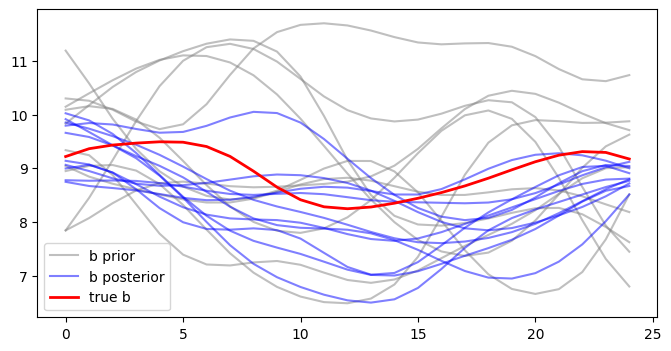

In [12]:
bw_traj = np.load("./data/bw_traj.npy")
bw = np.load("./data/bw.npy")
b_true = np.load("./data/b_true.npy")

# plt.plot(aw_traj[1],color="grey")
# plt.plot(aw_traj[-1],color="blue")
# plt.plot(a_true[:],color="green")

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(bw, color='gray', alpha=0.5)
ax.plot(bw_traj[-1], color='blue', alpha=0.5)
ax.plot(b_true, color='red', linewidth=2)
ax.plot([], color='gray', alpha=0.5, label="b prior")
ax.plot([], color='blue', alpha=0.5, label="b posterior")
ax.plot([], color='red', linewidth=2, label="true b")
ax.legend()
ax.legend()
plt.show()

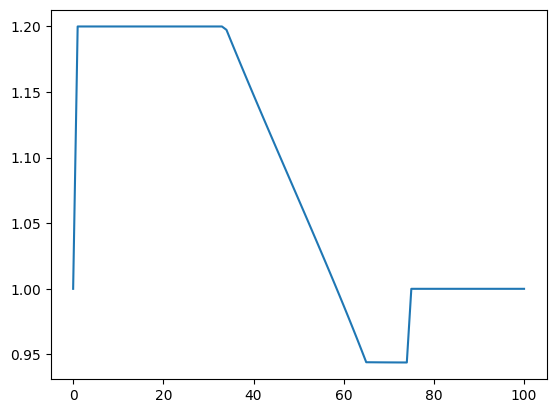

In [14]:
plt.plot(qmpc)